In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install split-folders
!pip install split-folders
import splitfolders

# Split dataset into train/val/test
data_path = "/content/drive/MyDrive/Land_Classification_Project/Copy of dataset /EuroSAT_RGB/EuroSAT_RGB"
splitfolders.ratio(
    data_path,
    output="/content/EuroSAT_split",
    seed=42,
    ratio=(0.7, 0.15, 0.15)
)

train_path = "/content/EuroSAT_split/train"
val_path   = "/content/EuroSAT_split/val"
test_path  = "/content/EuroSAT_split/test"

Copying files: 27000 files [18:14, 24.66 files/s] 


In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Mixed precision (faster on GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Parameters
IMG_SIZE = (128, 128)  # Reduced size
BATCH = 16

# Data Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7,1.3],
    horizontal_flip=True
).flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical'
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


In [ ]:
# Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # Freeze for first stage

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(train_gen.num_classes, activation='softmax', dtype='float32')  # ensure output is float32
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# Stage 1: Train top layers
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # reduced
    steps_per_epoch=train_gen.samples//BATCH,
    validation_steps=val_gen.samples//BATCH,
    callbacks=[early_stop, lr_scheduler]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 1799s 2s/step - accuracy: 0.6825 - loss: 0.9409 - val_accuracy: 0.8113 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 2/5
   1/1181 ━━━━━━━━━━━━━━━━━━━━ 25:54 1s/step - accuracy: 0.7500 - loss: 0.6715

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 293s 247ms/step - accuracy: 0.7500 - loss: 0.6715 - val_accuracy: 0.8115 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 3/5
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 1737s 1s/step - accuracy: 0.7975 - loss: 0.5832 - val_accuracy: 0.8024 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 4/5
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 325s 275ms/step - accuracy: 0.6875 - loss: 0.8850 - val_accuracy: 0.8019 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 5/5
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 1815s 1s/step - accuracy: 0.8278 - loss: 0.5080 - val_accuracy: 0.8041 - val_loss: 0.5721 - learning_rate: 3.0000e-04


In [ ]:
# Stage 2: Fine-tuning last layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
checkpoint_path = "/content/drive/MyDrive/Land_Classification_Project/final_model_finetuned.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1)

# Fine-tune
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,  # fine-tuning أكثر
    steps_per_epoch=train_gen.samples//BATCH,
    validation_steps=val_gen.samples//BATCH,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

print("✅ Fine-tuning completed. Final model saved at:", checkpoint_path)



Epoch 1/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5469 - loss: 1.7721
Epoch 1: val_loss improved from inf to 0.72212, saving model to /content/drive/MyDrive/Land_Classification_Project/final_model_finetuned.h5


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 10419s 9s/step - accuracy: 0.5470 - loss: 1.7716 - val_accuracy: 0.7695 - val_loss: 0.7221 - learning_rate: 1.0000e-05
Epoch 2/15
   1/1181 ━━━━━━━━━━━━━━━━━━━━ 2:24:09 7s/step - accuracy: 0.7500 - loss: 0.6414

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.72212
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 283s 234ms/step - accuracy: 0.7500 - loss: 0.6414 - val_accuracy: 0.7710 - val_loss: 0.7226 - learning_rate: 1.0000e-05
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7648 - loss: 0.7368
Epoch 3: val_loss improved from 0.72212 to 0.53534, saving model to /content/drive/MyDrive/Land_Classification_Project/final_model_finetuned.h5


1181/1181 ━━━━━━━━━━━━━━━━━━━━ 10023s 8s/step - accuracy: 0.7648 - loss: 0.7368 - val_accuracy: 0.8177 - val_loss: 0.5353 - learning_rate: 1.0000e-05
Epoch 4/15
   1/1181 ━━━━━━━━━━━━━━━━━━━━ 2:57:56 9s/step - accuracy: 0.8125 - loss: 0.6566
Epoch 4: val_loss did not improve from 0.53534
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 320s 264ms/step - accuracy: 0.8125 - loss: 0.6566 - val_accuracy: 0.8182 - val_loss: 0.5360 - learning_rate: 1.0000e-05
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7965 - loss: 0.6191

254/254 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.7716 - loss: 0.6385
Test Accuracy: 79.85%
254/254 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.79      0.85       450
              Forest       0.83      0.97      0.89       450
HerbaceousVegetation       0.91      0.35      0.50       450
             Highway       0.73      0.81      0.77       375
          Industrial       0.83      0.87      0.85       375
             Pasture       0.81      0.67      0.74       300
       PermanentCrop       0.55      0.84      0.67       375
         Residential       0.80      0.99      0.89       450
               River       0.77      0.71      0.74       375
             SeaLake       0.97      0.94      0.96       450

            accuracy                           0.80      4050
           macro avg       0.81      0.80      0.79      4050
        weighted avg       0.82      0.80      0.79 

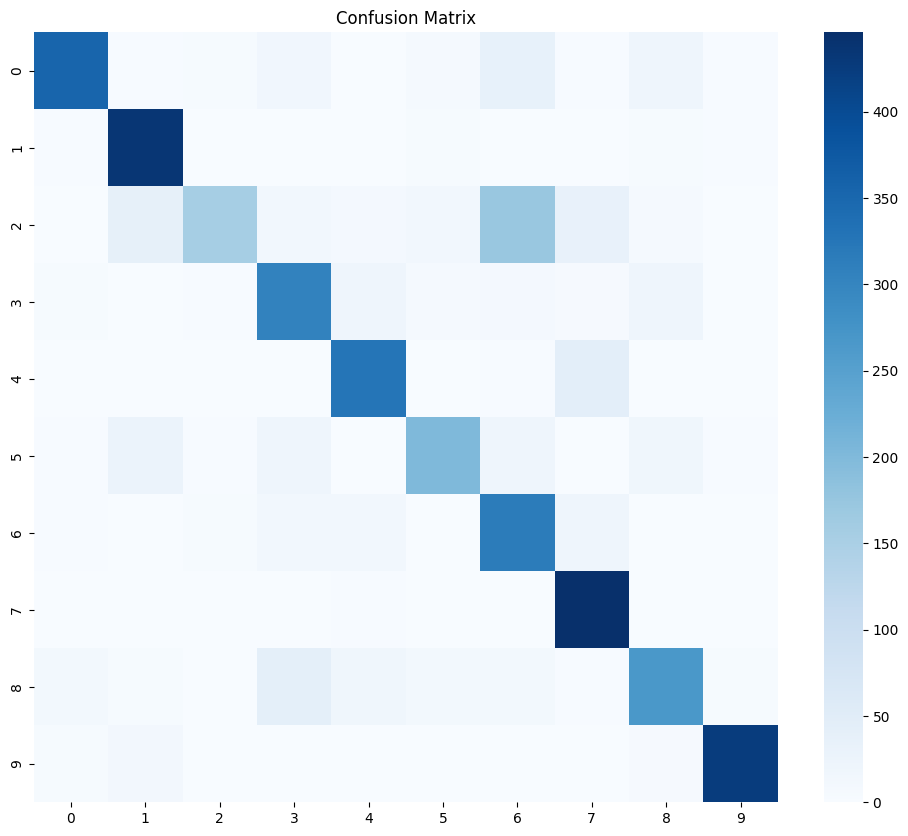

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Classification Report & Confusion Matrix
y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
final_model_path = "/content/drive/MyDrive/Land_Classification_Project/final_model.h5"
model.save(final_model_path)
print("🚀 Final model saved successfully!")

🚀 Final model saved successfully!
